In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import operator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
EXCLUDE_KEYS = EXCLUDE_KEYS + [54,55] + [23,24] # Same structure even though listed as different files
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m


def compute_sample_weights(y, lim=LIM, mul=MUL, up_lim=None, up_mul=None):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = np.abs(lim-v)*mul
        if up_lim is not None:
            if v > up_lim:
                if up_mul is not None:
                    ret[i] = np.abs(lim-v)*up_mul
                else:
                    ret[i] = np.abs(lim-v)*mul
    return ret

def create_train_test_matrices(train_keys, test_keys, handle_repeats='average'):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS, handle_repeats=handle_repeats)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
#     y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
#     y_buck_train = excel_train['Output: logKbucket'].values
    
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x4_train, x4_dims = create_x4_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x4_test = create_x4_matrix(L_test, max_dims=x4_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x40_x47_train = excel_train.iloc[:, 3:-1]
    master_train, master_names = prepare_master(x40_x47_train)
    
    x40_x47_test = excel_test.iloc[:, 3:-1]
    master_test, master_names = prepare_master(x40_x47_test)
    
    X_train = np.hstack((x4_train,x4_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x4_test, x4_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels_x4(train_keys, test_keys, h=1, handle_repeats='average'):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS, handle_repeats=handle_repeats)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
#     y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
#     y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_kernels(h=1, num_directions=1, bandwidth=1.0, x_type='x1', exclude_keys=EXCLUDE_KEYS, handle_repeats='average'):
    excel = parse_master_file(exclude_keys=exclude_keys, handle_repeats=handle_repeats)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
#     y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    if x_type == 'x1':
        for l in L_test:
                diags_test.append(compute_diagram(parse_x1(l)[['X', 'Y', 'Z']].values))
    if x_type == 'x4':
        for l in L_test:
            diags_test.append(compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values))
    if x_type == 'x5':
        for l in L_test:
            diags_test.append(compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=num_directions, bandwidth=bandwidth)
    
    D = SW.fit_transform(dd)
    
    return (D, y_test)

def get_diag(k, h=1): 
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    l = get_filename_list(excel[excel['Key'] == k]['Associated data'])[0]
    dgm = compute_diagram(parse_x4(l)[['Val1', 'Val2', 'Val3']].values)
    return dgm
    
    
def remove_for_loo(D, i, kernel=True):
    if kernel:
        D_train = np.delete(np.delete(D, i, axis=0), i, axis=1)
        D_test = np.delete(D[i], i, axis=0).reshape(1,-1)
    else:
        D_train = np.delete(D,i,axis=0)
        D_test = D[i].reshape(1,-1)
    return D_train, D_test
    

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS, handle_repeats='average').reset_index(drop=True)
keys = list(excel['Key'])
L = get_filename_list(excel['Associated data'])

In [5]:
excel.tail(10)

,Input,Key,Associated data,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI,Output: logK
136,194,211,SB_386,A,298.00,0,0,0,7.0,0,N,7.95
137,195,212,SB_387,B,298.00,0,0,0,7.0,0,N,5.52
138,196,213,SB_389,A,298.00,0,0,0,7.0,0,N,8.74
139,197,214,SB_390,A,298.00,0,0,0,7.0,0,N,8.14
140,198,215,SB_391,A,298.00,0,0,0,7.0,0,N,4.00
141,199,216,SB_901,C,298.15,0,0,0,7.0,0,N,6.54
142,200,217,SB_902,C,298.15,0,0,0,7.0,0,N,0.10
143,201,218,SB_903,C,298.15,0,0,0,7.0,6,CI_2,0.10
144,202,219,SB_904,C,298.15,0,0,0,7.0,2,CI_2,0.10
145,203,220,SB_905,C,298.15,0,0,0,7.0,2,Cl_2,0.10


In [6]:
# exclude_keys_min_test = [k for k in EXCLUDE_KEYS if k not in TEST_KEYS]
# excel_test = parse_master_file(exclude_keys=(keys+exclude_keys_min_test)).reset_index(drop=True)
# L_test = get_filename_list(excel_test['Associated data'])

In [7]:
x10_x17 = excel.iloc[:, 3:-1]
x10_x17.head()

,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI
0,A,298.0,0,0,0,7.0,0,N
1,A,298.0,0,0,0,7.0,1,CI_2
2,A,298.0,0,0,0,7.0,2,CI_1
3,A,298.0,0,0,0,7.0,2,CI_2
4,A,298.0,0,0,0,7.0,2,CI_2


In [8]:
idx_901 = int(excel[excel['Associated data'] == 'SB_901'].index[0])
idx_902 = int(excel[excel['Associated data'] == 'SB_902'].index[0])
print(idx_901, idx_902)

141 142


In [9]:
master, master_names = prepare_master(x10_x17)
K_train = master
K_train = rbf_kernel(K_train)
K_test = np.delete(K_train[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
K_train = np.delete(np.delete(K_train, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)

In [10]:
D_train_x3 = create_x3_matrix(L)
D_train_x3 = laplacian_kernel(D_train_x3)
D_test_x3 = np.delete(D_train_x3[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
D_train_x3 = np.delete(np.delete(D_train_x3, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)

50 50


In [11]:
D_train_x6 = create_x6_matrix(L, max_dims=(50, 6))
D_train_x6 = laplacian_kernel(D_train_x6)
D_test_x6 = np.delete(D_train_x6[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
D_train_x6 = np.delete(np.delete(D_train_x6, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)

In [12]:
D_train_x5b = create_x5_matrix(L)[:,0].reshape(-1, 1)
D_train_x5b = rbf_kernel(D_train_x5b)
D_test_x5b = np.delete(D_train_x5b[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
D_train_x5b = np.delete(np.delete(D_train_x5b, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)

In [13]:
D_train_x7 = create_x7_matrix(L)
D_train_x7 = rbf_kernel(D_train_x7)
D_test_x7 = np.delete(D_train_x7[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
D_train_x7 = np.delete(np.delete(D_train_x7, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)

In [14]:
# test_set_x1 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x1')
# test_set_x4 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x4')
# test_set_x5 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x5')

# D_x1 = test_set_x1[0]
# D_x4 = test_set_x4[0]
# D_x5 = test_set_x5[0]
# y = test_set_x1[1]

In [15]:
Gammas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Cs = [0.1, 1, 5, 10]
Epsilons = [1e-4, 1e-2, 1e-1, 1, 10]
num_directions = [1, 2]
bandwidths = [1.0, 2.0]
lims = [1, 2, 5]
muls = [0.1, 1, 2, 5, 10]

best_params = [0,0,0,0,0,0,0]
best_operators = None
best_score = float('inf')
best_cvs = None
operator_seqs = list(itertools.product([operator.add,operator.mul], repeat=5))

up_lim = 0
up_mul = 0

results = []

for direction in num_directions:
    for bandwidth in bandwidths:
        train_set_x1 = create_test_diagram_kernels(num_directions=direction, bandwidth=bandwidth, h=1, x_type='x1')
        train_set_x4 = create_test_diagram_kernels(num_directions=direction, bandwidth=bandwidth, h=1, x_type='x4')
        train_set_x5 = create_test_diagram_kernels(num_directions=direction, bandwidth=bandwidth, h=1, x_type='x5')
        D_train_x1 = train_set_x1[0]
        D_train_x4 = train_set_x4[0]
        D_train_x5 = train_set_x5[0]
        
        D_test_x1 = np.delete(D_train_x1[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
        D_test_x4 = np.delete(D_train_x4[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
        D_test_x5 = np.delete(D_train_x5[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
        
        D_train_x1 = np.delete(np.delete(D_train_x1, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
        D_train_x4 = np.delete(np.delete(D_train_x4, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
        D_train_x5 = np.delete(np.delete(D_train_x5, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
        
        y_train = train_set_x1[1]
        y_test = y_train[idx_901:idx_902+1]
        y_train = np.delete(y_train, [idx_901,idx_902], axis=0)
        
        
        for lim in lims:
            print(direction, bandwidth, lim)
            for mul in muls:
                for gamma in Gammas:
#                     master, master_names = prepare_master(x10_x17)
                    K_train = master
                    K_train = rbf_kernel(K_train, gamma=gamma)
                    K_test = np.delete(K_train[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
                    K_train = np.delete(np.delete(K_train, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
                    
                    D_train_x3 = create_x3_matrix(L)
                    D_train_x3 = laplacian_kernel(D_train_x3, gamma=gamma)
                    D_test_x3 = np.delete(D_train_x3[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
                    D_train_x3 = np.delete(np.delete(D_train_x3, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
                    
#                     D_train_x5b = create_x5_matrix(L)[:,0].reshape(-1,1)
#                     D_train_x5b = rbf_kernel(D_train_x5b, gamma=gamma)
#                     D_test_x5b = np.delete(D_train_x5b[191:193], [191,192], axis=1)
#                     D_train_x5b = np.delete(np.delete(D_train_x5b, [191,192], axis=0), [191,192], axis=1)
                    
                    D_train_x6 = create_x6_matrix(L, max_dims=(50, 6))
                    D_train_x6 = laplacian_kernel(D_train_x6, gamma=gamma)
                    D_test_x6 = np.delete(D_train_x6[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
                    D_train_x6 = np.delete(np.delete(D_train_x6, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)
                    
                    D_train_x7 = create_x7_matrix(L)
                    D_train_x7 = rbf_kernel(D_train_x7, gamma=gamma)
                    D_test_x7 = np.delete(D_train_x7[idx_901:idx_902+1], [idx_901,idx_902], axis=1)
                    D_train_x7 = np.delete(np.delete(D_train_x7, [idx_901,idx_902], axis=0), [idx_901,idx_902], axis=1)      
                    
                    for epsilon in Epsilons:
                        for c in Cs:
                            for operator_seq in operator_seqs:
                                
                                DD_train = operator_seq[4](operator_seq[3](operator_seq[2](operator_seq[1](operator_seq[0](D_train_x1, D_train_x3),D_train_x4), D_train_x5), D_train_x6), D_train_x7)
                                DD_test = operator_seq[4](operator_seq[3](operator_seq[2](operator_seq[1](operator_seq[0](D_test_x1, D_test_x3),D_test_x4), D_test_x5), D_test_x6), D_test_x7)

                                sws = compute_sample_weights(y_train, lim=lim, mul=mul)

                                clf = svm.SVR(kernel='precomputed', epsilon=epsilon, C=c)
                                cvs = cross_val_score(clf, DD_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', fit_params={'sample_weight':sws})
                                clf.fit(DD_train,y_train, sample_weight=sws)
                                prediction = clf.predict(DD_test)
                                score = np.mean(np.abs(prediction - np.array(y_test)))
                                results.append({'score':score, 'cvs': cvs, 'mean_cvs':cvs.mean(), 'predicted_0':prediction[0], 'predicted_1':prediction[1], 'actual_0':y_test[0], 'actual_1':y_test[1], 'direction':direction, 'bandwidth':bandwidth, 'lim':lim, 'mul':mul, 'gamma':gamma, 'epsilon':epsilon, 'c':c, 'operator_seq':operator_seq})

#                                 print('Score: {}, Direction: {}, Bandwidth: {}, Lim: {}, Mul: {}, Gamma: {}, Epsilon: {}, C: {}'.format(score, direction, bandwidth, lim, mul, gamma, epsilon, c))
#                                 print(operator_seq)


Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel
1 1.0 1
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
1 1.0 2
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
1 1.0 5
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel
1 2.0 1
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
1 

In [16]:
res_df_all = pd.DataFrame(results)
res_df_all.head()

,actual_0,actual_1,bandwidth,c,cvs,direction,epsilon,gamma,lim,mean_cvs,mul,operator_seq,predicted_0,predicted_1,score
0,6.54,0.1,1.0,0.1,"[-1.6774287264654386, -2.8935644195478636, -1....",1,0.0001,0.00001,1,-2.119184,0.1,"(<built-in function add>, <built-in function a...",6.530788,6.466467,3.187840
1,6.54,0.1,1.0,0.1,"[-1.6068765204865818, -2.951933872769831, -1.4...",1,0.0001,0.00001,1,-2.188452,0.1,"(<built-in function add>, <built-in function a...",6.047873,6.047873,3.220000
2,6.54,0.1,1.0,0.1,"[-1.633414015465759, -2.8771228619707765, -1.3...",1,0.0001,0.00001,1,-2.112648,0.1,"(<built-in function add>, <built-in function a...",6.269234,6.212542,3.191654
3,6.54,0.1,1.0,0.1,"[-1.6067448857100426, -2.956743528084789, -1.4...",1,0.0001,0.00001,1,-2.191434,0.1,"(<built-in function add>, <built-in function a...",6.038266,6.038266,3.220000
4,6.54,0.1,1.0,0.1,"[-1.6764539328852313, -2.8932889389795227, -1....",1,0.0001,0.00001,1,-2.119306,0.1,"(<built-in function add>, <built-in function a...",6.528563,6.465550,3.188493


In [17]:
res_df_all[res_df_all['mean_cvs'] == res_df_all['mean_cvs'].max()]

,actual_0,actual_1,bandwidth,c,cvs,direction,epsilon,gamma,lim,mean_cvs,mul,operator_seq,predicted_0,predicted_1,score
192706,6.54,0.1,2.0,5.0,"[-1.4333631858917817, -2.461745485834696, -1.1...",2,0.0001,0.0001,2,-1.845014,0.1,"(<built-in function add>, <built-in function a...",5.290875,5.130795,3.13996


In [18]:
res_df_all[(res_df_all['predicted_0'] > 5.4) & (res_df_all['predicted_1'] < 3.5)]

,actual_0,actual_1,bandwidth,c,cvs,direction,epsilon,gamma,lim,mean_cvs,mul,operator_seq,predicted_0,predicted_1,score


In [19]:
res_df_all[(res_df_all['score'] == res_df_all['score'].min())]

,actual_0,actual_1,bandwidth,c,cvs,direction,epsilon,gamma,lim,mean_cvs,mul,operator_seq,predicted_0,predicted_1,score
38644,6.54,0.1,1.0,10.0,"[-2.008103908355517, -2.836230292312705, -1.45...",1,0.01,0.00001,5,-2.126238,0.1,"(<built-in function mul>, <built-in function a...",5.009365,3.190748,2.310692


In [21]:
res_df_all.to_csv('../data/results/both/x1x3x4x5x5bx6x7_no_dups.csv')

In [22]:
test_set_x1 = create_test_diagram_kernels(num_directions=1, bandwidth=1., h=1, x_type='x1')
test_set_x4 = create_test_diagram_kernels(num_directions=1, bandwidth=1., h=1, x_type='x4')
test_set_x5 = create_test_diagram_kernels(num_directions=1, bandwidth=1., h=1, x_type='x5')

D_x1 = test_set_x1[0]
D_x4 = test_set_x4[0]
D_x5 = test_set_x5[0]
y = test_set_x1[1]

Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel
Computing Test Diagrams
Computing Kernel


In [23]:
K_train = master
K = rbf_kernel(K_train, gamma=0.00001)

D_x3 = create_x3_matrix(L)
D_x3 = laplacian_kernel(D_x3, gamma=0.00001)

D_x6 = create_x6_matrix(L, max_dims=(50, 6))
D_x6 = laplacian_kernel(D_x6, gamma=0.00001)

50 50


In [24]:
results_2 = []
for i in range(D_x1.shape[0]):
    y_train = np.delete(y, i, 0)
    y_test = y[i]
    K_train, K_test = remove_for_loo(K,i)
    D_train_x1, D_test_x1 = remove_for_loo(D_x1,i)
    D_train_x3, D_test_x3 = remove_for_loo(D_x3,i)
    D_train_x4, D_test_x4 = remove_for_loo(D_x4,i)
    D_train_x5, D_test_x5 = remove_for_loo(D_x5,i)
    D_train_x6, D_test_x6 = remove_for_loo(D_x6,i)
    
    DD_train = D_train_x1+D_train_x3+D_train_x4+D_train_x5+D_train_x6#+K_train
    DD_test = D_test_x1+D_test_x3+D_test_x4+D_test_x5+D_test_x6#+K_test
    
#     sws = compute_sample_weights(y_train, lim=2, mul=10)
    
#     DD_train = D_train
#     DD_test = D_test
#     clf = KernelRidge(kernel='precomputed', alpha=.000001)
#     clf = KernelRidge(kernel='linear', alpha=1e-5)

#     clf.fit(D_train,y_train)
    clf = svm.SVR(kernel='precomputed', epsilon=0.01, C=10)
#     clf = svm.LinearSVR(C=1, epsilon=0.1)
#     clf.fit(DD_train,y_train, sample_weight=sws)
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    results_2.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

In [25]:
res_df = pd.DataFrame(results_2)
print(np.median(np.abs(res_df['predicted'] - res_df['actual'])))
res_df.tail(10)

1.2036695241114255


,actual,key,predicted
136,7.95,211,7.583681
137,5.52,212,6.900049
138,8.74,213,6.869588
139,8.14,214,10.199098
140,4.00,215,8.294058
141,6.54,216,4.526284
142,0.10,217,1.318717
143,0.10,218,7.895142
144,0.10,219,7.303510
145,0.10,220,4.052632


Text(0,0.5,'Predicted logK')

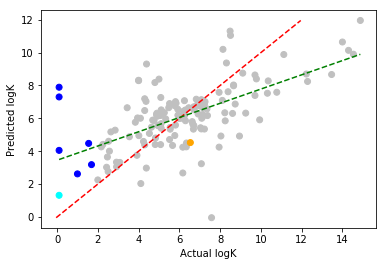

In [26]:
# res_df = res_df[(res_df['predicted'] < 16) & (res_df['predicted'] > -5)]
colors = ['cyan' if row['key'] == 217 else 'blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in res_df.iterrows()]
plt.scatter(res_df['actual'], res_df['predicted'], color=colors)
plt.plot([res_df['predicted'].min(),res_df['predicted'].max()],[res_df['predicted'].min(),res_df['predicted'].max()], 'r--')
plt.plot(np.unique(res_df['actual']), np.poly1d(np.polyfit(res_df['actual'], res_df['predicted'], 1))(np.unique(res_df['actual'])), 'g--')
plt.xlabel('Actual logK')
plt.ylabel('Predicted logK')

In [ ]:
train_set_x1 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x1')
train_set_x4 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x4')
train_set_x5 = create_test_diagram_kernels(num_directions=1, bandwidth=2., h=1, x_type='x5')
X1 = train_set_x1[0]
X4 = train_set_x4[0]
X5 = train_set_x5[0]

D_test_x1 = np.delete(X1[191:193], [191,192], axis=1)
D_test_x4 = np.delete(X4[191:193], [191,192], axis=1)
D_test_x5 = np.delete(X5[191:193], [191,192], axis=1)

D_train_x1 = np.delete(np.delete(X1, [191,192], axis=0), [191,192], axis=1)
D_train_x4 = np.delete(np.delete(X4, [191,192], axis=0), [191,192], axis=1)
D_train_x5 = np.delete(np.delete(X5, [191,192], axis=0), [191,192], axis=1)

y = train_set_x1[1]
y_test = y[191:193]
y_train = np.delete(y, [191,192], axis=0)
        
        
K = master
K = rbf_kernel(K, gamma=0.0001)
K_test = np.delete(K[191:193], [191,192], axis=1)
K_train = np.delete(np.delete(K, [191,192], axis=0), [191,192], axis=1)

X3 = create_x3_matrix(L)
X3 = laplacian_kernel(X3, gamma=0.0001)
D_test_x3 = np.delete(X3[191:193], [191,192], axis=1)
D_train_x3 = np.delete(np.delete(X3, [191,192], axis=0), [191,192], axis=1)

X5b = create_x5_matrix(L)[:,0].reshape(-1,1)
X5b = rbf_kernel(X5b, gamma=0.0001)
D_test_x5b = np.delete(X5b[191:193], [191,192], axis=1)
D_train_x5b = np.delete(np.delete(X5b, [191,192], axis=0), [191,192], axis=1)

X6 = create_x6_matrix(L, max_dims=(50, 6))
X6 = laplacian_kernel(X6, gamma=0.0001)
D_test_x6 = np.delete(X6[191:193], [191,192], axis=1)
D_train_x6 = np.delete(np.delete(X6, [191,192], axis=0), [191,192], axis=1)

X7 = create_x7_matrix(L)
X7 = rbf_kernel(X7, gamma=0.0001)
D_test_x7 = np.delete(X7[191:193], [191,192], axis=1)
D_train_x7 = np.delete(np.delete(X7, [191,192], axis=0), [191,192], axis=1)      

In [ ]:
alls = [X1, X3, X4, X5, X5b, X6, X7]
trains = [D_train_x1,D_train_x3,D_train_x4,D_train_x5,D_train_x5b,D_train_x6,D_train_x7,K_train]
tests = [D_test_x1,D_test_x3,D_test_x4,D_test_x5,D_test_x5b,D_test_x6,D_test_x7,K_test]
x_names = ['x1', 'x3', 'x4', 'x5', 'x5b', 'x6', 'x7', 'X10-X17']

In [ ]:
DD_train = 0
DD_test = 0
results = []
for i in range(len(trains)):
    DD_train += trains[i]
    DD_test += tests[i]

    clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)
    cvs = cross_val_score(clf, DD_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', fit_params={'sample_weight':sws})
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    score = np.mean(np.abs(prediction - np.array(y_test)))
    results.append({'score':score, 'cvs': cvs, 'mean_cvs':cvs.mean(), 'predicted_0':prediction[0], 'predicted_1':prediction[1], 'actual_0':y_test[0], 'actual_1':y_test[1], 'x_name': x_names[i]})


In [ ]:
res = pd.DataFrame(results)

In [ ]:
res.head(10)

In [ ]:
alls = [X1, X3, X4, X5, X5b, X6, X7]
trains = [D_train_x1,D_train_x3,D_train_x4,D_train_x5,D_train_x5b,D_train_x6,D_train_x7]
tests = [D_test_x1,D_test_x3,D_test_x4,D_test_x5,D_test_x5b,D_test_x6,D_test_x7]
x_names = ['x1', 'x3', 'x4', 'x5', 'x5b', 'x6', 'x7']

In [ ]:
DD_train = K_train
DD_test = K_test
DD = K
results = []
for t in range(len(trains)):
    DD_train += trains[t]
    DD_test += tests[t]

    clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)
    cvs = cross_val_score(clf, DD_train, y=y_train, cv=5, scoring='neg_mean_absolute_error')
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    score = np.mean(np.abs(prediction - np.array(y_test)))
    results.append({'score':score, 'cvs': cvs, 'mean_cvs':cvs.mean(), 'predicted_0':prediction[0], 'predicted_1':prediction[1], 'actual_0':y_test[0], 'actual_1':y_test[1], 'x_name': x_names[t]})
    
    results_2 = []
    for i in range(X1.shape[0]):
        y_train_here = np.delete(y, i, 0)
        y_test_here = y[i]
        DD += alls[t]
        DD_train_here, DD_test_here = remove_for_loo(DD, i)

        clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)

        clf.fit(DD_train_here,y_train_here)
        prediction = clf.predict(DD_test_here)
        results_2.append({'predicted':prediction[0], 'actual':y_test_here, 'key':keys[i]})

    graph_res = pd.DataFrame(results_2)
    colors = ['gray' for idx, row in graph_res.iterrows()]
#     colors = ['cyan' if row['key'] == 217 else 'blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in graph_res.iterrows()]
    plt.scatter(graph_res['actual'], graph_res['predicted'], color=colors)
    plt.plot([graph_res['predicted'].min(),graph_res['predicted'].max()],[graph_res['predicted'].min(),graph_res['predicted'].max()], 'r--')
    plt.plot(np.unique(graph_res['actual']), np.poly1d(np.polyfit(graph_res['actual'], graph_res['predicted'], 1))(np.unique(graph_res['actual'])), 'k--')
#     plt.xlabel('Actual logK')
#     plt.ylabel('Predicted logK')
#     plt.title('X Addition: {}'.format(x_names[t]))
    plt.show()
    plt.cla()



In [ ]:
res_K = pd.DataFrame(results)

In [ ]:
res_K.head(10)

In [ ]:
res_K.to_csv('../data/results/both/K_to_X7.csv')

In [ ]:
alls = [X1, X3, X4, X5, X5b, X6, X7, K]
trains = [D_train_x1,D_train_x3,D_train_x4,D_train_x5,D_train_x5b,D_train_x6,D_train_x7,K_train]
tests = [D_test_x1,D_test_x3,D_test_x4,D_test_x5,D_test_x5b,D_test_x6,D_test_x7,K_test]
x_names = ['x1', 'x3', 'x4', 'x5', 'x5b', 'x6', 'x7', 'X10-X17']

In [ ]:
DD_train_first = sum(trains)
DD_test_first = sum(tests)
DD = sum(alls)
results = []
for t in range(len(trains)):
    DD_train = DD_train_first - trains[t]
    DD_test += tests[t]

    clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)
    cvs = cross_val_score(clf, DD_train, y=y_train, cv=5, scoring='neg_mean_absolute_error')
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    score = np.mean(np.abs(prediction - np.array(y_test)))
    results.append({'score':score, 'cvs': cvs, 'mean_cvs':cvs.mean(), 'predicted_0':prediction[0], 'predicted_1':prediction[1], 'actual_0':y_test[0], 'actual_1':y_test[1], 'x_name': x_names[t]})
    
    results_2 = []
    for i in range(X1.shape[0]):
        y_train_here = np.delete(y, i, 0)
        y_test_here = y[i]
        DD += alls[t]
        DD_train_here, DD_test_here = remove_for_loo(DD, i)

        clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)

        clf.fit(DD_train_here,y_train_here)
        prediction = clf.predict(DD_test_here)
        results_2.append({'predicted':prediction[0], 'actual':y_test_here, 'key':keys[i]})

    graph_res = pd.DataFrame(results_2)
#     colors = ['cyan' if row['key'] == 217 else 'blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in graph_res.iterrows()]
    colors = ['gray' for idx, row in graph_res.iterrows()]
    plt.scatter(graph_res['actual'], graph_res['predicted'], color=colors)
    plt.plot([graph_res['predicted'].min(),graph_res['predicted'].max()],[graph_res['predicted'].min(),graph_res['predicted'].max()], 'r--')
    plt.plot(np.unique(graph_res['actual']), np.poly1d(np.polyfit(graph_res['actual'], graph_res['predicted'], 1))(np.unique(graph_res['actual'])), 'k--')
#     plt.xlabel('Actual logK')
#     plt.ylabel('Predicted logK')
#     plt.title('X Addition: {}'.format(x_names[t]))
    plt.show()
    plt.cla()

In [ ]:
alls = [X1, X3, X4, X5, X5b, X6, X7, K]
trains = [D_train_x1,D_train_x3,D_train_x4,D_train_x5,D_train_x5b,D_train_x6,D_train_x7,K_train]
tests = [D_test_x1,D_test_x3,D_test_x4,D_test_x5,D_test_x5b,D_test_x6,D_test_x7,K_test]
# x_names = ['x1', 'x3', 'x4', 'x5', 'x5b', 'x6', 'x7', 'X10-X17']
x_names = ['1', '2', '3', '4', '5', '6', '7', '8']

In [ ]:
results = []
for t in range(1, len(trains)+1):
    its_train = list(itertools.combinations(trains, t))
    its_test = list(itertools.combinations(tests, t))
    its_alls = list(itertools.combinations(alls, t))
    its_names = list(itertools.combinations(x_names, t))
    for j in range(len(its_train)):
        DD_train = sum(its_train[j])
        DD_test = sum(its_test[j])
        x_names_here = ', '.join(its_names[j])

        clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)
        cvs = cross_val_score(clf, DD_train, y=y_train, cv=5, scoring='neg_mean_absolute_error')
        clf.fit(DD_train,y_train)
        prediction = clf.predict(DD_test)
        score = np.mean(np.abs(prediction - np.array(y_test)))
        result = {'score':score, 'cvs': cvs, 'mean_cvs':cvs.mean(), 'std_cvs':cvs.std(), 'predicted_0':prediction[0], 'predicted_1':prediction[1], 'actual_0':y_test[0], 'actual_1':y_test[1], 'x_name': x_names_here}

        results_2 = []
        DD = sum(its_alls[j])
        for i in range(X1.shape[0]):
            y_train_here = np.delete(y, i, 0)
            y_test_here = y[i]
            DD_train_here, DD_test_here = remove_for_loo(DD, i)

            clf = svm.SVR(kernel='precomputed', epsilon=0.0001, C=10)

            clf.fit(DD_train_here,y_train_here)
            prediction = clf.predict(DD_test_here)
            results_2.append({'predicted':prediction[0], 'actual':y_test_here, 'key':keys[i]})
        
        graph_res = pd.DataFrame(results_2)
        result['loo_score'] = np.mean(np.abs(graph_res['predicted'] - graph_res['actual']))
        result['loo_std'] = np.std(np.abs(graph_res['predicted'] - graph_res['actual']))
        results.append(result)
        
        graph_res.to_csv('../data/results/both/leave_one_out/{}.csv'.format(x_names_here))
        
#         colors = ['cyan' if row['key'] == 217 else 'blue' if (row['actual'] < 2) else 'orange' if row['key'] == 216 else 'silver' for idx, row in graph_res.iterrows()]
        colors = ['gray' for idx, row in graph_res.iterrows()]
        plt.scatter(graph_res['actual'], graph_res['predicted'], color=colors)
        plt.plot([graph_res['predicted'].min(),graph_res['predicted'].max()],[graph_res['predicted'].min(),graph_res['predicted'].max()], 'r--')
        plt.plot(np.unique(graph_res['actual']), np.poly1d(np.polyfit(graph_res['actual'], graph_res['predicted'], 1))(np.unique(graph_res['actual'])), 'k--')
        plt.xlabel('Experimental logK', fontweight='bold')
        plt.ylabel('Predicted logK', fontweight='bold')
        plt.tick_params(direction='in')
        plt.title('{}'.format(x_names_here))
        plt.savefig('../data/results/both/leave_one_out/{}.png'.format(x_names_here), format='png', dpi=200)
        plt.cla()

In [ ]:
combs_df = pd.DataFrame(results)

In [ ]:
combs_df.head()

In [ ]:
combs_df.to_csv('../data/results/both/all_combinations_2.csv')